In [ ]:
import os
import re
import json
import pandas as pd
from textwrap import wrap
from openai import OpenAI
from prettytable import PrettyTable
from tqdm import tqdm

# Create new `pandas` methods which use `tqdm` progress
tqdm.pandas()

## Extract and filter data:

**Annotated:** Contains actual reviews and interpretable column names for L1 categories

In [2]:
df = pd.read_csv("../230418_GreatSchools_Revised_Annotated_Data.csv", low_memory=False)
df.head(3)

,Unnamed: 0,sch_ID,sch_name,sch_state,sch_county,status,sch_type,sch_level,sch_mean_ach,sch_grade_slope_mean_ach,...,L2_extracurricular/electives,L2_offering,L2_school finances,L2_family,L2_quality indicator,L2_teacher quality,L2_preparation,L2_postsecondary/graduation,L2_instruction,L2_curriculum/curricular materials
0,0,10000500870,Albertville Middle School,AL,MARSHALL COUNTY,1.0,tps,Middle,-0.331363,NaN,...,0,0,0,0,1,0,0,0,0,0
1,1,10000500871,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,1.0,tps,High,NaN,NaN,...,1,1,0,0,1,0,0,1,1,1
2,2,10000500871,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,1.0,tps,High,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
categories = [column.strip("L1_1") for column in df.columns if "L1" in column and "other" not in column]
# l2_vars = [column for column in df.columns if "L2" in column]
display(categories)


['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

In [4]:
labels = pd.read_excel("../220517.REACH.Half_Keywords_with_Semantic_Neighbors_Additional Words Added.xlsx")
labels.head(3)

,Charter,Trad_Pub,Private,Good_Rev,Bad_Rev,Good_Sch,Bad_Sch,Keyword,Relevant,Include,...,Next 5 Words,Unnamed: 17,Unnamed: 18,Charter_Rel_Freq,Trad_Pub_Rel_Freq,Private_Rel_Freq,Good_Rev_Rel_Freq,Bad_Rev_Rel_Freq,Good_Sch_Rel_Freq,Bad_Sch_Rel_Freq
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,charter,1.0,NaN,...,"['dps', 'county', 'pubic', 'cps', 'chater']",NaN,NaN,0.001343,0.000077,0.000039,0.000201,0.000177,0.000187,0.000169
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,academy,1.0,NaN,...,"['sonoran', 'rutgers', 'coastal', 'poly', 'poi...",NaN,NaN,0.001143,0.000132,0.000749,0.000534,0.000166,0.000383,0.000373
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,need,1.0,NaN,...,"['deserve', 'requires', 'try', 'requiring', 'r...",NaN,NaN,0.000910,0.000963,0.000634,0.000716,0.001115,0.000816,0.000971


In [5]:
list(labels["Level 1 Broad Category"].unique())

[nan,
 'Physical Environment',
 'School Culture  ',
 'Instruction & Learning',
 'Resources',
 'Overall Quality',
 'Other',
 'School Staff',
 'School-Level Features',
 'school culture',
 'instruction & learning',
 'other',
 'school-level features',
 'resources',
 'overall quality',
 'physical environment',
 'school staff']

**Coded:** Contains student-coded labels for each review. Contains 500 human-coded reviews. Indexes match Annotated file

In [6]:
coded_reviews = pd.read_excel("../coded_reviews.xlsx", skiprows=1)
display(coded_reviews.head(3))
len(coded_reviews)

,reviewid,l1_instruction,l1_overallquality,l1_phyenvironment,l1_resources,l1_culture,l1_staff,l1_features,instruction,phyenvironment,resources,overallquality,culture,staff,features
0,101303,0,0,0,0,0,1,0,1,1,1,1,0,1,0
1,101508,1,1,0,1,1,1,0,1,0,1,1,0,1,0
2,102269,0,1,0,0,0,0,0,0,0,0,1,1,0,0


500

In [7]:
# Mapping from annotated data to coded reviews:

mapping = {
    # annotated_column : coded_column
    'L1_school-level features': 'features',
    'L1_physical environment': 'phyenvironment',
    'L1_instruction & learning': 'instruction',
    'L1_school staff': 'staff',
    'L1_overall quality': 'overallquality',
    'L1_school culture': 'culture',
    'L1_resources': 'resources'
}

In [8]:
[cat.strip("L1_") for cat in mapping.keys()]

['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

## Clean sheet:

1. Annotated:
    - Extract first 500 rows with a subset of relevant columns

2. Coded:
    - Remove unnecessary columns

3. Merge Annotated and Coded by index

In [9]:
annotated = df[ ["comments", "who", 
               "review_star_rating", "sch_name", "sch_state", 
               "sch_county", "sch_type"] + list(mapping.keys())].iloc[:500]

annotated = annotated.rename({column:"nlp_"+column.strip("L1_") for column in list(mapping.keys())}, axis=1)
annotated.head(1)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,nlp_school staff,nlp_overall quality,nlp_school culture,nlp_resources
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,1,1,1,0


In [10]:
coded = coded_reviews[ ['reviewid', 'instruction',
       'phyenvironment', 'resources', 'overallquality', 'culture', 'staff',
       'features', 'l1_instruction',
       'l1_phyenvironment', 'l1_resources', 'l1_overallquality', 'l1_culture', 'l1_staff',
       'l1_features'] ]

coded = coded.rename({
    'instruction': 'instruction & learning',
    'phyenvironment': 'physical environment',
    'resources': 'resources',
    'overallquality': 'overall quality',
    'culture': 'school culture',
    'staff': 'school staff',
    'features': 'school-level features',
    'l1_instruction': 'l1 instruction & learning',
    'l1_phyenvironment': 'l1 physical environment',
    'l1_resources': 'l1 resources',
    'l1_overallquality': 'l1 overall quality',
    'l1_culture': 'l1 school culture',
    'l1_staff': 'l1 school staff',
    'l1_features': 'l1 school-level features'
}, axis=1)
coded.head(2)

,reviewid,instruction & learning,physical environment,resources,overall quality,school culture,school staff,school-level features,l1 instruction & learning,l1 physical environment,l1 resources,l1 overall quality,l1 school culture,l1 school staff,l1 school-level features
0,101303,1,1,1,1,0,1,0,0,0,0,0,0,1,0
1,101508,1,0,1,1,0,1,0,1,0,1,1,1,1,0


### Merge Annotated and Coded

In [11]:
full_df = pd.merge(annotated, coded, left_index=True, right_index=True)
full_df.head(2)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,school culture,school staff,school-level features,l1 instruction & learning,l1 physical environment,l1 resources,l1 overall quality,l1 school culture,l1 school staff,l1 school-level features
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0,1,0,0,0,0,0,0,1,0
1,I attended Albertville High School my freshman...,student,2.0,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,tps,1,1,1,...,0,1,0,1,0,1,1,1,1,0


## Call GPT

In [28]:
import difflib



def match_column(column):
    closest_matches = difflib.get_close_matches(column, column_names, n=1, cutoff=0)
    # If we have at least one match, return the first one. Otherwise, return None.
    if closest_matches:
        return closest_matches[0]
    return None

In [38]:
client = OpenAI()

def clean(s):
    """Remove alphanumeric characters"""
    pattern = re.compile('[\W_]+')
    return pattern.sub('', s)

def get_gpt_pred(categories, comment, model="gpt-3.5-turbo", query=None):
    '''
    Calls ChatGPT API with given model and comment, returns series with predictons.
    Different models interpret the formatting aspect of the prompt differently, which can lead to unexpected errors.
    Raises error when formatting of response is not interpretable. 
    '''
    
    # formatting = 'Follow these instructions precisely. When provided with this input:\n {"content":content, "categories":categories} \
    #               determine which of the categories are discussed in the content, and always respond with a list of the following format\n ["category: 0 or 1" ...]'
    
    # query = f'"content":{comment},"content":{str(categories)}'
    if query==None:
        query = "Which of these topics: " + str(categories) + f'\n\nAre discussed in this review: "{comment}". For all topics, respond in the format: "topic": 0 or 1.'

    completion = client.chat.completions.create(
        model=model,
        messages=[
            # {"role":"user", "content":formatting},
            {"role":"user", "content":query}
        ],
        temperature=0.1, # creativity/randomness (lower is more deterministic, less random)
        top_p=0.1 # top token propbability mass (lower is restrictive)
    )
    response = completion.choices[0].message.content

    model_designation = model.split('-')[1]+"_"

    if "\n" in response:
        predictions = re.sub("[{}\"-]", "", response).split("\n")
    elif ", " in response:
        predictions = re.sub("[{}\"-]", "", response).split(", ")
    else:
        print(f"ERROR: could not find delimiter using model: {model}, here's the text:\n {response}")
        return pd.Series({model_designation+"output":response})

    try:
        # create series from dict of model+category and the predicted value
        series = {}
        for prediction in predictions:
            column = model_designation+match_column(prediction.split(": ")[0], categories)
            series[column] = clean(prediction.split(": ")[1])
        series[model_designation+"output"] = predictions
    except Exception as e:
        print(f"ERROR: parsing failed. here's the exception:\n {e}\n\nhere's the text:\n {response}\n\nand here's the parsed text:\n {predictions}")
        return pd.Series({model_designation+"output":response})
    return pd.Series(series)


## 3.5 Test:

In [39]:
response35 = get_gpt_pred(categories, full_df.iloc[0].comments, model="gpt-3.5-turbo")
response35

3.5_school-level features                                                     0
3.5_physical environment                                                      0
3.5_instruction & learning                                                    1
3.5_school staff                                                              1
3.5_overall quality                                                           1
3.5_school culture                                                            1
3.5_resources                                                                 0
3.5_output                    [schoollevel features: 0, physical environment...
dtype: object

## 4.0 Test:

In [14]:
response40 = get_gpt_pred(categories, full_df.iloc[0].comments, model="gpt-4")
response40

4_school-level features                                                     0
4_physical environment                                                      0
4_instruction & learning                                                    1
4_school staff                                                              1
4_overall quality                                                           1
4_school culture                                                            1
4_resources                                                                 0
4_output                    [school-level features: 0, physical environmen...
dtype: object

## Full test on subset of 20:

In [15]:
full_df_subset = full_df
full_df_subset.head(1)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,school culture,school staff,school-level features,l1 instruction & learning,l1 physical environment,l1 resources,l1 overall quality,l1 school culture,l1 school staff,l1 school-level features
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0,1,0,0,0,0,0,0,1,0


In [19]:
# Get 3.5 predictions:
predictions_35_df = full_df_subset["comments"].apply(lambda x: get_gpt_pred(categories, x, "gpt-3.5-turbo"))
predictions_35_df.head(1)

ERROR: could not find delimiter using model: gpt-3.5-turbo, here's the text:
 "school staff": 1
ERROR: could not find delimiter using model: gpt-3.5-turbo, here's the text:
 "school staff": 1
ERROR: could not find delimiter using model: gpt-3.5-turbo, here's the text:
 "school staff": 1
ERROR: could not find delimiter using model: gpt-3.5-turbo, here's the text:
 "school staff": 1


,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output,3.5_- school-level features,3.5_- physical environment,3.5_- instruction & learning,3.5_- school staff,3.5_- overall quality,3.5_- school culture,3.5_- resources
0,0,0,1,1,0,1,0,"[school-level features: 0, physical environmen...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Sanity check 3.5 output (should have 7 items, one for each category):
predictions_35_df["3.5_output"].apply(lambda x: (len(x))).unique()

array([ 7, 17,  3,  2])

In [26]:
predictions_35_df.columns

Index(['3.5_school-level features', '3.5_physical environment',
       '3.5_instruction & learning', '3.5_school staff', '3.5_overall quality',
       '3.5_school culture', '3.5_resources', '3.5_output',
       '3.5_- school-level features', '3.5_- physical environment',
       '3.5_- instruction & learning', '3.5_- school staff',
       '3.5_- overall quality', '3.5_- school culture', '3.5_- resources'],
      dtype='object')

In [21]:
final_df = pd.merge(full_df_subset, predictions_35_df, left_index=True, right_index=True)
final_df.head(1)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,3.5_school culture,3.5_resources,3.5_output,3.5_- school-level features,3.5_- physical environment,3.5_- instruction & learning,3.5_- school staff,3.5_- overall quality,3.5_- school culture,3.5_- resources
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,1,0,"[school-level features: 0, physical environmen...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Get 4.0 predictions:
predictions_40_df = full_df_subset[14:]["comments"].progress_apply(lambda x: get_gpt_pred(categories, x, "gpt-4"))
predictions_40_df.head(1)

ERROR: parsing failed. here's the exception:
 list index out of range

here's the text:
 {
"school-level features": 0,
"physical environment": 0,
"instruction & learning": 0,
"school staff": 1,
"overall quality": 1,
"school culture": 1,
"resources": 0
}

and here's the parsed text: ['', 'school-level features: 0,', 'physical environment: 0,', 'instruction & learning: 0,', 'school staff: 1,', 'overall quality: 1,', 'school culture: 1,', 'resources: 0', '']


UnboundLocalError: local variable 'series' referenced before assignment

In [ ]:
# Sanity check 4.0 output (should have 7 items, one for each category):
predictions_40_df["4_output"].apply(lambda x: (len(x))).unique()

array([7])

In [ ]:
final_df = pd.merge(final_df, predictions_40_df, left_index=True, right_index=True)
final_df.head(1)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,3.5_resources,3.5_output,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0,"[school-level features: 0, physical environmen...",0,0,1,1,1,1,0,"[school-level features: 0, physical environmen..."


## Compare using Jaccard Similarity:

In [ ]:
def jaccard_similarity(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Vectors must be of equal length")

    intersection = sum(int(el1) and int(el2) for el1, el2 in zip(vector1, vector2))
    union = sum(int(el1) or int(el2) for el1, el2 in zip(vector1, vector2))

    if union == 0:
        return 0.0  # to handle the case where both vectors are empty
    else:
        return intersection / union

In [ ]:
sort_categories = ['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

def get_jaccard_similarity(x):
    # Get feature lists:
    coded = list(x[sort_categories])
    gpt_35 = list(x[["3.5_"+cat for cat in sort_categories]])
    gpt_40 = list(x[["4_"+cat for cat in sort_categories]])

    return pd.Series({"j_sim_35":jaccard_similarity(coded, gpt_35),"j_sim_4":jaccard_similarity(coded, gpt_40)})

In [ ]:
final_df[["j_sim_35", "j_sim_4"]] = final_df.apply(get_jaccard_similarity, axis=1)

In [ ]:
final_df.columns

Index(['comments', 'who', 'review_star_rating', 'sch_name', 'sch_state',
       'sch_county', 'sch_type', 'nlp_school-level features',
       'nlp_physical environment', 'nlp_instruction & learning',
       'nlp_school staff', 'nlp_overall quality', 'nlp_school culture',
       'nlp_resources', 'reviewid', 'instruction & learning',
       'physical environment', 'resources', 'overall quality',
       'school culture', 'school staff', 'school-level features',
       'l1 instruction & learning', 'l1 physical environment', 'l1 resources',
       'l1 overall quality', 'l1 school culture', 'l1 school staff',
       'l1 school-level features', '3.5_school-level features',
       '3.5_physical environment', '3.5_instruction & learning',
       '3.5_school staff', '3.5_overall quality', '3.5_school culture',
       '3.5_resources', '3.5_output', '4_school-level features',
       '4_physical environment', '4_instruction & learning', '4_school staff',
       '4_overall quality', '4_school cultur

In [ ]:
def compare_predictions(x):
	output = "\n---------------------------------------------------------------------------------------------------\n" + "\n".join(wrap(text=x["comments"], width=100)) + "\n"

	coded = list(x[sort_categories])
	gpt_35 = list(x[["3.5_"+cat for cat in sort_categories]])
	gpt_40 = list(x[["4_"+cat for cat in sort_categories]])
	nlp = list(x[["l1 "+cat for cat in sort_categories]])

	table = PrettyTable()
	table.add_column("category", sort_categories)
	table.add_column("hum", coded)
	table.add_column("3.5", gpt_35)
	table.add_column("4.0", gpt_40)
	table.add_column("nlp", nlp)

	print(output)
	print(table)
	print(f"Jaccard similarity 3.5: {jaccard_similarity(coded, gpt_35):}")
	print(f"Jaccard similarity 4.0: {jaccard_similarity(coded, gpt_40):}")

In [ ]:
final_df.columns

Index(['comments', 'who', 'review_star_rating', 'sch_name', 'sch_state',
       'sch_county', 'sch_type', 'nlp_school-level features',
       'nlp_physical environment', 'nlp_instruction & learning',
       'nlp_school staff', 'nlp_overall quality', 'nlp_school culture',
       'nlp_resources', 'reviewid', 'instruction & learning',
       'physical environment', 'resources', 'overall quality',
       'school culture', 'school staff', 'school-level features',
       'l1 instruction & learning', 'l1 physical environment', 'l1 resources',
       'l1 overall quality', 'l1 school culture', 'l1 school staff',
       'l1 school-level features', '3.5_school-level features',
       '3.5_physical environment', '3.5_instruction & learning',
       '3.5_school staff', '3.5_overall quality', '3.5_school culture',
       '3.5_resources', '3.5_output', '4_school-level features',
       '4_physical environment', '4_instruction & learning', '4_school staff',
       '4_overall quality', '4_school cultur

In [ ]:
final_df.apply(compare_predictions, axis=1);


---------------------------------------------------------------------------------------------------
(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BULLYING AND FIGHTS I went here when I was a kid and it
was bad and now it is worst as it has ever been I well adment the teachers are ok I loved Mrs.Long
and Mrs.Right but there were lots of fights and lots of people in my class was below grade level and
had 50's,40's,30's,and even F's SO I would just like everyone to know about this school.Thanks

+------------------------+-----+-----+-----+-----+
|        category        | hum | 3.5 | 4.0 | nlp |
+------------------------+-----+-----+-----+-----+
| school-level features  |  0  |  0  |  0  |  0  |
|  physical environment  |  1  |  0  |  0  |  0  |
| instruction & learning |  1  |  1  |  1  |  0  |
|      school staff      |  1  |  1  |  1  |  1  |
|    overall quality     |  1  |  0  |  1  |  0  |
|     school culture     |  0  |  1  |  1  |  0  |
|       resources        |  1  |  0  |  0  | 

<Axes: ylabel='Frequency'>

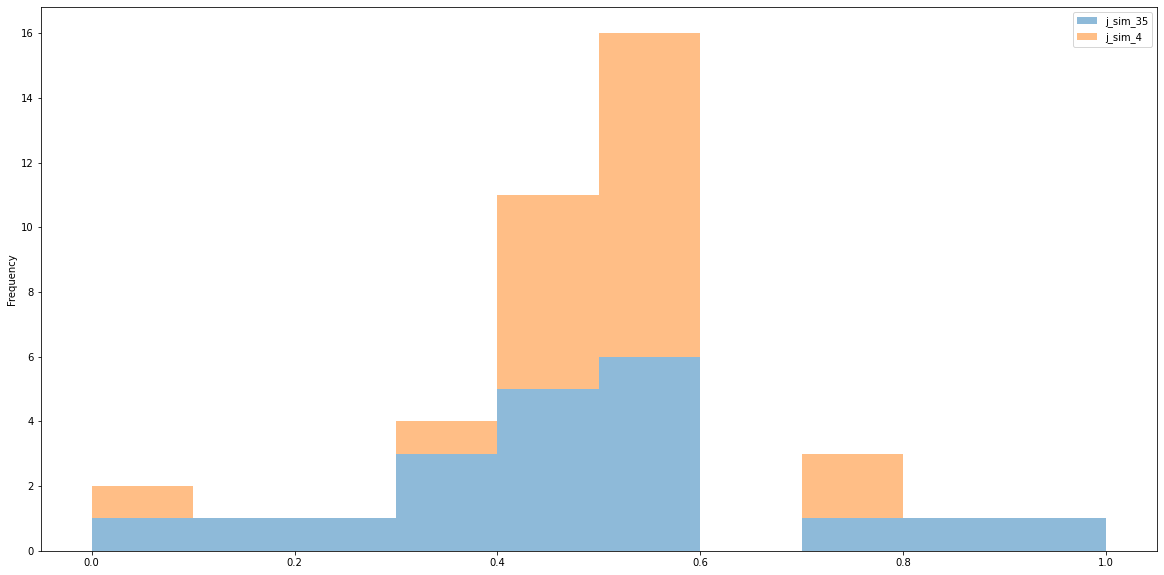

In [ ]:
display(final_df[["j_sim_35", "j_sim_4"]].plot.hist(figsize=(20,10), stacked=True, alpha=0.5))

In [ ]:
final_df.to_csv("subset_test_20.csv", index=False)

## Notes

ChatGPT's output is extremely finicky due to the probabilistic nature of the output. This can be limited to some extent but ChatGPT really wants to have unique outputs. It's definitely not designed to work in a functional setting but it can be made to do so. 

Here are the options available to standardize output:
- Prompt engineering: Specify output formatting in the prompt
  - Quick, usually works
  - Sometimes we need to get very specific, eating up our token limit...
- Mode Hyperparameters: Set low tolerance for stochastic chaos
  - Ordinarily variance in responses is fine, but functional use makes this irritating
  - Turn down creativity and limit the token pool to the highest probaiblities to reduce formatting inconsistencies
- Model fine-tuning: Train a ChatGPT to return in an expected format on this particular task
  - Takes time
  - Will gurantee formatting as expected

Required specificity in queries means that token counts increase, but compute time also increases significantly.


TODO: False positive / false negative rate relative to human annotators per category
- Table/graph FP FN wrt human annotators
- Use keyword matching NLP thing from doc and check as well (high FP wrt humans)
- Find another dataset

